# Maritime Merge
Perform merge on MARITIME MTYC1 - MEYC1 and MARITIME SMOC1 - ICAC1

## Step 0: Environment set-up

In [14]:
from functools import reduce
import datetime
from pandas import *
import boto3
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from io import BytesIO, StringIO

import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket

import s3fs

# import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(
    "ignore", category=ShapelyDeprecationWarning
)  # Warning is raised when creating Point object from coords. Can't figure out why.

plt.rcParams["figure.dpi"] = 300

In [15]:
# AWS credentials
s3 = s3fs.S3FileSystem #must be set to this to use such commands as ls
#s3 = boto3.resource('s3')
s3_client = boto3.client('s3')

## AWS buckets
bucket = "wecc-historical-wx"
qaqcdir = "3_qaqc_wx/VALLEYWATER/"
mergedir = "4_merge_wx/VALLEYWATER/"

In [16]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary
temp_dir = "./tmp"
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [17]:
def read_nc_from_s3_clean(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket

    Parameters
    ----------
    network_name: str
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")

    Returns
    -------
    station_data: xr.Dataset

    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file
    I'd like to see us use a zarr workflow if possible to avoid this.

    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir=temp_dir, prefix="", suffix=".nc", delete=True
    )

    # Create s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = "s3://wecc-historical-wx/2_clean_wx/{}/{}.nc".format(
        network_name, station_id
    )

    # Read in the data using xarray
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine="h5netcdf").load()

    # Close temporary file
    temp_file.close()

    return station_data

In [18]:
def read_zarr_from_s3(station_id, temp_dir):
    """Read zarr file containing station data for a single station of interest from AWS s3 bucket

    Parameters
    ----------
    network_name: str
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")

    Returns
    -------
    station_data: xr.Dataset

    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file
    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir=temp_dir, prefix="", suffix=".zarr", delete=True
    )

    # Create s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = "s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_{}.zarr".format(
        station_id
    )
    print(s3_url)

    # Read in the data using xarray
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine="zarr").load()

    # Close temporary file
    temp_file.close()

    return station_data

In [19]:
def qaqc_ds_to_df(ds, verbose=False):
    """Converts xarray ds for a station to pandas df in the format needed for the pipeline

    Parameters
    ----------
    ds : xr.Dataset
        input data from the clean step
    verbose : bool, optional
        if True, provides runtime output to the terminal

    Returns
    -------
    df : pd.DataFrame
        converted xr.Dataset into dataframe
    MultiIndex : pd.Index
        multi-index of station and time
    attrs : list of str
        attributes from xr.Dataset
    var_attrs : list of str
        variable attributes from xr.Dataset
    era_qc_vars : list of str
        QAQC variables

    Notes
    -----
    This is the notebook friendly version (no logger statements).
    """
    ## Add qc_flag variable for all variables, including elevation;
    ## defaulting to nan for fill value that will be replaced with qc flag

    for key, val in ds.variables.items():
        if val.dtype == object:
            if key == "station":
                if str in [type(v) for v in ds[key].values]:
                    ds[key] = ds[key].astype(str)
            else:
                if str in [type(v) for v in ds.isel(station=0)[key].values]:
                    ds[key] = ds[key].astype(str)

    exclude_qaqc = [
        "time",
        "station",
        "lat",
        "lon",
        "qaqc_process",
        "sfcWind_method",
        "pr_duration",
        "pr_depth",
        "PREC_flag",
        "rsds_duration",
        "rsds_flag",
        "anemometer_height_m",
        "thermometer_height_m",
    ]  # lat, lon have different qc check

    raw_qc_vars = []  # qc_variable for each data variable, will vary station to station
    era_qc_vars = []  # our ERA qc variable
    old_era_qc_vars = []  # our ERA qc variable

    for var in ds.data_vars:
        if "q_code" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variable, need to keep for comparison, then drop
        if "_qc" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
        if "_eraqc" in var:
            era_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
            old_era_qc_vars.append(var)

    print(f"era_qc existing variables:\n{era_qc_vars}")
    n_qc = len(era_qc_vars)

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars and "_eraqc" not in var:
            qc_var = var + "_eraqc"  # variable/column label

            # if qaqc var does not exist, adds new variable in shape of original variable with designated nan fill value
            if qc_var not in era_qc_vars:
                print(f"nans created for {qc_var}")
                ds = ds.assign({qc_var: xr.ones_like(ds[var]) * np.nan})
                era_qc_vars.append(qc_var)

    print("{} created era_qc variables".format(len(era_qc_vars) - len(old_era_qc_vars)))
    if len(era_qc_vars) != n_qc:
        print("{}".format(np.setdiff1d(old_era_qc_vars, era_qc_vars)))

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var: ds[var].attrs for var in list(ds.data_vars.keys())}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df = ds.to_dataframe()

    # instrumentation heights
    if "anemometer_height_m" not in df.columns:
        try:
            df["anemometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.anemometer_height_m
            )
        except:
            print("Filling anemometer_height_m with NaN.", flush=True)
            df["anemometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass
    if "thermometer_height_m" not in df.columns:
        try:
            df["thermometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.thermometer_height_m
            )
        except:
            print("Filling thermometer_height_m with NaN.", flush=True)
            df["thermometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass

    # De-duplicate time axis
    df = df[~df.index.duplicated()].sort_index()

    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df["station"] = station

    # Station pd.Series to str
    station = station.unique().values[0]

    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()

    # Add time variables needed by multiple functions
    df["hour"] = pd.to_datetime(df["time"]).dt.hour
    df["day"] = pd.to_datetime(df["time"]).dt.day
    df["month"] = pd.to_datetime(df["time"]).dt.month
    df["year"] = pd.to_datetime(df["time"]).dt.year
    df["date"] = pd.to_datetime(df["time"]).dt.date

    return df  # , MultiIndex, attrs, var_attrs, era_qc_vars

## New Functions

In [7]:
def hourly_standardization(df):
    """

    Resamples meteorological variables to hourly timestep according to standard conventions.

    Rules
    ------
        1.) top of the hour: take the first value in each hour
            - standard convention for temperature, dewpoint, wind speed, direction, relative humidity, air pressure
        2.) summation across hour: sum observations within each hour
            - standard convention for precipitation and solar radiation
        3.) constant across the hour: take the first value in each hour
            - this applies to variables, like station name and location, that do not change within each hour

    Parameters
    ------
        df: pd.DataFrame
            station dataset converted to dataframe through QAQC pipeline
        verbose: boolean
            input for printf() to print to log file - set in script initialization

    Returns
    -------
        if success:
            df [pd.DataFrame]
                QAQC dataframe with all columns resampled to one hour (column name retained)
        if failure:
            None
    """

    print(
        "Running: hourly_standardization",
        # verbose=verbose,
            # log_file=log_file,
            flush=True,
    )

    ##### define the variables for each sub-dataframe #####

    # Variables that remain constant within each hour
    constant_vars = [
        "time",
        "station",
        "lat",
        "lon",
        "elevation", 
        "anemometer_height_m", 
        "thermometer_height_m",
        "sfcWind_method",
        "pr_duration"
    ]

    # Aggregation across hour variables, standard meteorological convention: precipitation and solar radiation
    sum_vars = ["time", 'pr_15min', "pr", "pr_localmid", "pr_24h", "pr_5min", "pr_1h", "rsds"]

    # Top of the hour variables, standard meteorological convention: temperature, dewpoint temperature, pressure, humidity, winds
    instant_vars = [
        "time",
        "tas",
        "tdps",
        "tdps_derived",
        "ps",
        "psl",
        "ps_altimeter",
        "ps_derived",
        "hurs",
        "sfcwind",
        "sfcwind_dir",
    ]

    # QAQC flags, which remain constants within each hour
    # NOTE: Unlike the lists above, this list does not contain 'time', which is added in the next step. 
    qaqc_vars = [
        'elevation_eraqc', 
        "tas_qc",
        "tas_eraqc",
        "pr_5min_eraqc",
        'pr_15min_eraqc', 
        "pr_1h_eraqc",
        "pr_5min_qc",
        "pr_eraqc",
        "pr_depth_qc",
        "ps_qc",
        "ps_altimeter_qc",
        "ps_eraqc",
        "ps_altimeter_eraqc",
        "psl_qc",
        "psl_eraqc",
        "tdps_qc",
        "tdps_eraqc",
        'raw_qc', 
        "sfcWind_qc",
        "sfcWind_dir_qc",
        "sfcWind_eraqc",
        "sfcWind_dir_eraqc",
        "qaqc_process",
    ]


    # All variables, necessary for producing columns with hourly counts for each variable
    # all_vars = constant_vars + sum_vars + instant_vars + qaqc_vars

    ##### Subset the dataframe according to rules
    constant_df = df[[col for col in constant_vars if col in df.columns]]

    qaqc_df = df[[col for col in qaqc_vars if col in df.columns if col != "time"]]
    qaqc_df = qaqc_df.astype(str)
    qaqc_df.insert(0, "time", df["time"])

    sum_df = df[[col for col in sum_vars if col in df.columns]]

    instant_df = df[[col for col in instant_vars if col in df.columns]]

    #####

    try:
        # If station does not report any variable, bypass
        if len(df.columns) == 0:
            print(
                "Empty dataset - bypassing hourly aggregation",
                # verbose=verbose,
                # log_file=log_file,
                flush=True,
            )
            return df
        else:
            result_list = []

            # Performing hourly aggregation, only if subset contains more than one (ie 'time') column
            ## This is to account for input dataframes that do not contain all subsets of variables defined above.
            if len(constant_df.columns) <= 1:
                print('')
                
            else:
                constant_result = constant_df.resample("1h", on="time").first()
                result_list.append(constant_result)
                print('appended constant result')

            if len(instant_df.columns) <= 1:
                print('')
            else:
                instant_result = instant_df.resample("1h", on="time").first()
                result_list.append(instant_result)

            if len(sum_df.columns) <= 1:
                print('')
                
            else:
                sum_result = sum_df.resample("1h", on="time").apply(
                    lambda x: np.nan if x.isna().all() else x.sum(skipna=True)
                )
                result_list.append(sum_result)
                print('appended sum result')

            if len(qaqc_df.columns) <= 1:
                print('')
                
            else:
                qaqc_result = qaqc_df.resample("1h", on="time").apply(
                    lambda x: ",".join(x.unique())
                )  # adding unique flags
                result_list.append(qaqc_result)
                print('appended qaqc result')

            # Aggregating and outputting reduced dataframe
            result = reduce(
                lambda left, right: pd.merge(left, right, on=["time"], how="outer"),
                result_list,
            )

            return result

    except Exception as e:
        print(
            "hourly_standardization failed with Exception: {0}".format(e),
            # verbose=verbose,
            # log_file=log_file,
            flush=True,
        )
        return None

In [8]:
# datatype libraries
float32_variables = ['anemometer_height_m',
                     'elevation',
                     'hurs',
                     'lat',
                     'lon',
                     'pr',
                     'pr_duration',
                     'pr_locamid'
                     'pr_24h',
                     'pr_5min',
                     'pr_1h',
                     'pr_15min',
                     'ps',
                     'psl',
                     'ps_altimeter',
                     'ps_derived',
                     'rsds',
                     'sfcwind',
                     'sfcwind_dir',
                     'thermometer_height_m', 
                     'tas',
                     'tdps',
                     'tdps_derived',
                     ]

# TODO: these should be int, not U16, 
# though this may be complicated by the 
# flags being converted to strings then concatenated
U16_variables = ['elevation_eraqc', 
                 'pr_5min_eraqc',
                 'pr_15min_eraqc', 
                 'pr_1h_eraqc',
                 'pr_5min_qc',
                 'pr_eraqc',
                 'pr_depth_qc',
                 'ps_qc',
                 'ps_altimeter_qc',
                 'ps_eraqc',
                 'ps_altimeter_eraqc',
                 'psl_qc',
                 'psl_eraqc',
                 'raw_qc', 
                 'sfcWind_qc',
                 'sfcWind_dir_qc',
                 'sfcWind_eraqc',
                 'sfcWind_dir_eraqc',
                 'sfcWind_method',
                 'tas_eraqc',
                 'tas_qc',
                 'tdps_qc',
                 'tdps_eraqc',
                 'qaqc_process',
                ]

In [9]:
#TODO: programmatize the attributes - I manually changed it to "maritime_merge"

def hourly_standardization_all_stations(filepath_list, input_prefix, output_prefix):
    """
    Applies any hourly standardization to all QAQC'd Valley Water zarrs then exports them to the merge folder in AWS.
    
    Rules
    ------
        1.) top of the hour: take the first value in each hour
            - standard convention for temperature, dewpoint, wind speed, direction, relative humidity, air pressure
        2.) summation across hour: sum observations within each hour
            - standard convention for precipitation and solar radiation
        3.) constant across the hour: take the first value in each hour
            - this applies to variables, like station name and location, that do not change within each hour

    Parameters
    ------
        filepath_list: list
            list of paths to all input Valley Water station zarr files
        input_prefix: string
            used to define the destination path
        ouput_prefix: string
            used to define the destination path

    Returns
    -------
        if success:
            all processed datasets are exported to the merge folder in AWS
        if failure:
            None
    """

    # Iterate over the zarr files and apply the function to each
    for obj in filepath_list:
        print(obj)
        # Only process zarr files (you can refine this check if needed)
        if obj.endswith('.zarr'):
            # Open the Zarr file with xarray from S3
            zarr_store = obj
            ds = xr.open_zarr(zarr_store)

            # Convert to df to apply hourly standardization function
            df = qaqc_ds_to_df(ds, verbose=False)
            
            # Apply the function to the dataset
            processed_df = hourly_standardization(df)

            # Add 'station' to the dataframe index
            processed_df.set_index('station', append=True, inplace=True)

            # Convert the processed dataFrame back to xarray.Dataset
            processed_ds = processed_df.to_xarray()

            # Convert all datatypes, to enable export     
            existing_float32 = [col for col in float32_variables if col in processed_df.columns]
            existing_U16 = [col for col in U16_variables if col in processed_df.columns]

            processed_ds[existing_float32] = processed_ds[existing_float32].astype('float32')
            processed_ds[existing_U16] = processed_ds[existing_U16].astype('U16')

            processed_ds.coords['station'] = processed_ds.coords['station'].astype('<U16')

            ##### Update attributes
            # Carry over the attributes from original dataset
            processed_ds.attrs = ds.attrs

            # Update 'history' attribute
            timestamp = datetime.datetime.utcnow().strftime("%m-%d-%Y, %H:%M:%S")
            processed_ds.attrs["history"] = ds.attrs[
                    "history"
                ] + " \nmaritime_merge.ipynb run on {} UTC".format(timestamp)
            
            # Update 'comment' attribute
            processed_ds.attrs["comment"] = "Final v1 data product. This data has been subjected to cleaning, QA/QC, and standardization."
            
            # ##### Export 
            # Define the destination file path in the output folder
            output_key = obj.replace(input_prefix, output_prefix, 1)
            # Export the processed dataset to the output folder in S3
            processed_ds.to_zarr(output_key, mode='w')
            print(f"Processed and exported: {output_key} \n")
            
    return None



## Step 1: Hourly Standardization


In [20]:
def hourly_standardization_all_stations_nc(filepath_list, output_prefix):
    """
    Applies any hourly standardization to all QAQC'd Valley Water zarrs then exports them to the merge folder in AWS.
    
    Rules
    ------
        1.) top of the hour: take the first value in each hour
            - standard convention for temperature, dewpoint, wind speed, direction, relative humidity, air pressure
        2.) summation across hour: sum observations within each hour
            - standard convention for precipitation and solar radiation
        3.) constant across the hour: take the first value in each hour
            - this applies to variables, like station name and location, that do not change within each hour

    Parameters
    ------
        filepath_list: list
            list of paths to all input Valley Water station zarr files
        input_prefix: string
            used to define the destination path
        ouput_prefix: string
            used to define the destination path
        network: string
            used as input to read_nc_from_s3_clean


    Returns
    -------
        if success:
            all processed datasets are exported to the merge folder in AWS
        if failure:
            None
    """

    # Iterate over the nc files and apply the function to each
    for obj in filepath_list:
        # Open nc file
        ds = read_nc_from_s3_clean('MARITIME',obj,temp_dir)

        # Convert to df to apply hourly standardization function
        df = qaqc_ds_to_df(ds, verbose=False)
        
        # Apply the function to the dataset
        processed_df = hourly_standardization(df)

        # Add 'station' to the dataframe index
        processed_df.set_index('station', append=True, inplace=True)

        # Convert the processed dataFrame back to xarray.Dataset
        processed_ds = processed_df.to_xarray()

        # Convert all datatypes, to enable export     
        existing_float32 = [col for col in float32_variables if col in processed_df.columns]
        existing_U16 = [col for col in U16_variables if col in processed_df.columns]

        processed_ds[existing_float32] = processed_ds[existing_float32].astype('float32')
        processed_ds[existing_U16] = processed_ds[existing_U16].astype('U16')

        processed_ds.coords['station'] = processed_ds.coords['station'].astype('<U16')

        ##### Update attributes
        # Carry over the attributes from original dataset
        processed_ds.attrs = ds.attrs

        # Update 'history' attribute
        timestamp = datetime.datetime.utcnow().strftime("%m-%d-%Y, %H:%M:%S")
        processed_ds.attrs["history"] = ds.attrs[
                "history"
            ] + " \n_maritime_merge.ipynb run on {} UTC".format(timestamp)
        
        # Update 'comment' attribute
        processed_ds.attrs["comment"] = "Final v1 data product. This data has been subjected to cleaning, QA/QC, and standardization."

        # ##### Export 
        # Define the destination file path in the output folder
        export_url = "s3://wecc-historical-wx/{}{}.zarr".format(output_prefix, obj)
        print(export_url)
        processed_ds.to_zarr(export_url, mode='w')
        print(f"Processed and exported: {obj} \n")
            
    return None


In [24]:
# First, list paths to the maritime stations nc's

import_path = 's3://wecc-historical-wx/2_clean_wx/MARITIME/'

station_list = []

for obj in s3.ls(import_path):
    if obj.endswith('nc'):
        station_list.append('s3://'+ obj)
        #print(obj)
else:
    print("Folder is empty.")


file_names = []

for path in station_list:
    filename = path.rsplit('/', 1)[-1].rsplit('.', 1)[0]
    file_names.append(filename)



TypeError: AbstractFileSystem.ls() missing 1 required positional argument: 'path'

In [119]:
maritime_cleaned_dir = "2_clean_wx/MARITIME/"
maritime_merged_dir = "4_merge_wx/MARITIME_dev/"

In [ ]:
hourly_standardization_all_stations_nc(file_names, maritime_merged_dir)

era_qc existing variables:
[]
nans created for sfcWind_eraqc
nans created for sfcWind_dir_eraqc
nans created for elevation_eraqc
3 created era_qc variables
[]
Running: hourly_standardization
appended constant result


appended qaqc result
s3://wecc-historical-wx/4_merge_wx/MARITIME_dev/MARITIME_PFDC1.zarr
Processed and exported: MARITIME_PFDC1 

era_qc existing variables:
[]
nans created for ps_eraqc
nans created for tas_eraqc
nans created for sfcWind_eraqc
nans created for sfcWind_dir_eraqc
nans created for elevation_eraqc
5 created era_qc variables
[]
Running: hourly_standardization
appended constant result

appended qaqc result
s3://wecc-historical-wx/4_merge_wx/MARITIME_dev/MARITIME_PFXC1.zarr
Processed and exported: MARITIME_PFXC1 

era_qc existing variables:
[]
nans created for ps_eraqc
nans created for tas_eraqc
nans created for sfcWind_eraqc
nans created for sfcWind_dir_eraqc
nans created for elevation_eraqc
5 created era_qc variables
[]
Running: hourly_standardization
appended

### Checks

In [31]:
# exported datasets
export_path = 's3://wecc-historical-wx/4_merge_wx/MARITIME_dev/'

station_list_export = []

for obj in s3.ls(export_path):
    if obj.endswith('.zarr'):

        station_list_export.append(obj)
        #print(obj)
else:
    print("Folder is empty.")


# imported zarrs
import_path = 's3://wecc-historical-wx/2_clean_wx/MARITIME/'

station_list_import = []

for obj in s3.ls(import_path):
    if obj.endswith('.nc'):

        station_list_import.append(obj)
        #print(obj)
else:
    print("Folder is empty.")

Folder is empty.
Folder is empty.


In [33]:
len(station_list_import)
#len(station_list_export)

80

## Step 2: Concatenate overlapping stations

#### Concatenation function

1. open the datasets that need to be concatenated
2. split the two datasets into subsets

TODO: could instead split into time ranges

3. concatenate the subsets

TODO: OR, following the line of logic above, pull from certain datasets depending on the time range subsets

4. update attributes
5. delete the original datasets
6. export the final concatented dataset


In [112]:
def delete_folder(bucket_name, folder_name):
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    
    for obj in bucket.objects.filter(Prefix=folder_name+'/'):
        obj.delete()
    
    bucket.delete_objects(
        Delete={
            'Objects': [
                {
                    'Key': folder_name
                }
            ]
        }
    )

In [ ]:
def concatenate_target_stations(network_name,station_old,station_new):
    """

    Rules
    ------

    Parameters
    ------


    Returns
    -------
        if success:
            all processed datasets are exported to the merge folder in AWS
        if failure:
            None
    """
    # Import target datasets and convert to dataframe
    old_url = "s3://wecc-historical-wx/4_merge_wx/{}_dev/{}_{}.zarr".format(network_name, network_name, station_old)
    new_url = "s3://wecc-historical-wx/4_merge_wx/{}_dev/{}_{}.zarr".format(network_name, network_name, station_new)

    ds_old = xr.open_zarr(old_url)
    ds_new = xr.open_zarr(new_url)

    df_old = ds_old.to_dataframe()
    df_new = ds_new.to_dataframe()

    # Apply reset index only to 'time', as we will need that for concatenation
    df_old = df_old.reset_index(level='time')
    df_new = df_new.reset_index(level='time')

    ##### Split datframes into subsets #####

    # Remove data in time overlap between old and new
    df_old_cleaned = df_old[~df_old['time'].isin(df_new['time'])]
    df_new_cleaned = df_new[~df_new['time'].isin(df_old['time'])]

    # Data in new input that overlaps in time with old input
    df_overlap = df_new[df_new['time'].isin(df_old['time'])]

    # Set index to new input for df_old_cleaned
    # We want the final dataset to show up as the new station, not the old
    final_station_name = "{}_{}".format(network_name,station_new)
    new_index = [final_station_name] * len(df_old_cleaned)

    df_old_cleaned.index = new_index
    df_old_cleaned.index.name = 'station'
    
    ##### Concatenate subsets #####

    df_concat = concat([df_old_cleaned, df_overlap, df_new_cleaned])

    # Add 'time' back into multi index
    df_concat.set_index('time', append=True, inplace=True)
    
    
    # Convert concatenated dataframe to dataset
    ds_concat = df_concat.to_xarray()

    ##### Update attributes and datatypes #####

    # Include past attributes
    ds_concat.attrs = ds_new.attrs 
    

    # Update 'history' attribute
    timestamp = datetime.datetime.utcnow().strftime("%m-%d-%Y, %H:%M:%S")
    ds_concat.attrs["history"] = ds_new.attrs[
            "history"
        ] + " \nmaritime_merge.ipynb run on {} UTC".format(timestamp)
    
    # Update 'comment' attribute
    ds_concat.attrs["comment"] = "Final v1 data product. This data has been subjected to cleaning, QA/QC, and standardization."
    
    # Add new qaqc_files_merged attribute
    ds_concat.attrs["qaqc_files_merged"] = "{}_{}, {}_{} merged. Overlap retained from newer station data.".format(network_name,station_old,network_name,station_new)
    
    # Convert all datatypes, to enable export     
    existing_float32 = [col for col in float32_variables if col in df_concat.columns]
    existing_U16 = [col for col in U16_variables if col in df_concat.columns]

    ds_concat[existing_float32] = ds_concat[existing_float32].astype('float32')
    ds_concat[existing_U16] = ds_concat[existing_U16].astype('U16')

    ds_concat.coords['station'] = ds_concat.coords['station'].astype('<U16')
    
    # ### Export ###
    
    # # delete old inputs 
    # bucket = "wecc-historical-wx"
    # key_new = "4_merge_wx/{}_dev/{}_{}.zarr".format(network_name, network_name, station_new)
    # key_old = "4_merge_wx/{}_dev/{}_{}.zarr".format(network_name, network_name, station_old)

    # delete_folder(bucket,key_new)
    # delete_folder(bucket,key_old)

    # # Export final, concatenated dataset
    # export_url = "s3://wecc-historical-wx/4_merge_wx/{}_dev/{}_{}.zarr".format(network_name, network_name, station_new)
    # ds_concat.to_zarr(export_url, mode='w')
     
    return ds_concat



In [114]:
concatenate_target_stations('MARITIME','MTYC1','MEYC1')

deletion complete


KeyError: 'ps_eraqc'

In [25]:
file_names = ['MARITIME_MTYC1','MARITIME_MEYC1']
hourly_standardization_all_stations_nc(file_names, maritime_merged_dir)

NameError: name 'maritime_merged_dir' is not defined

#### Visualizing results

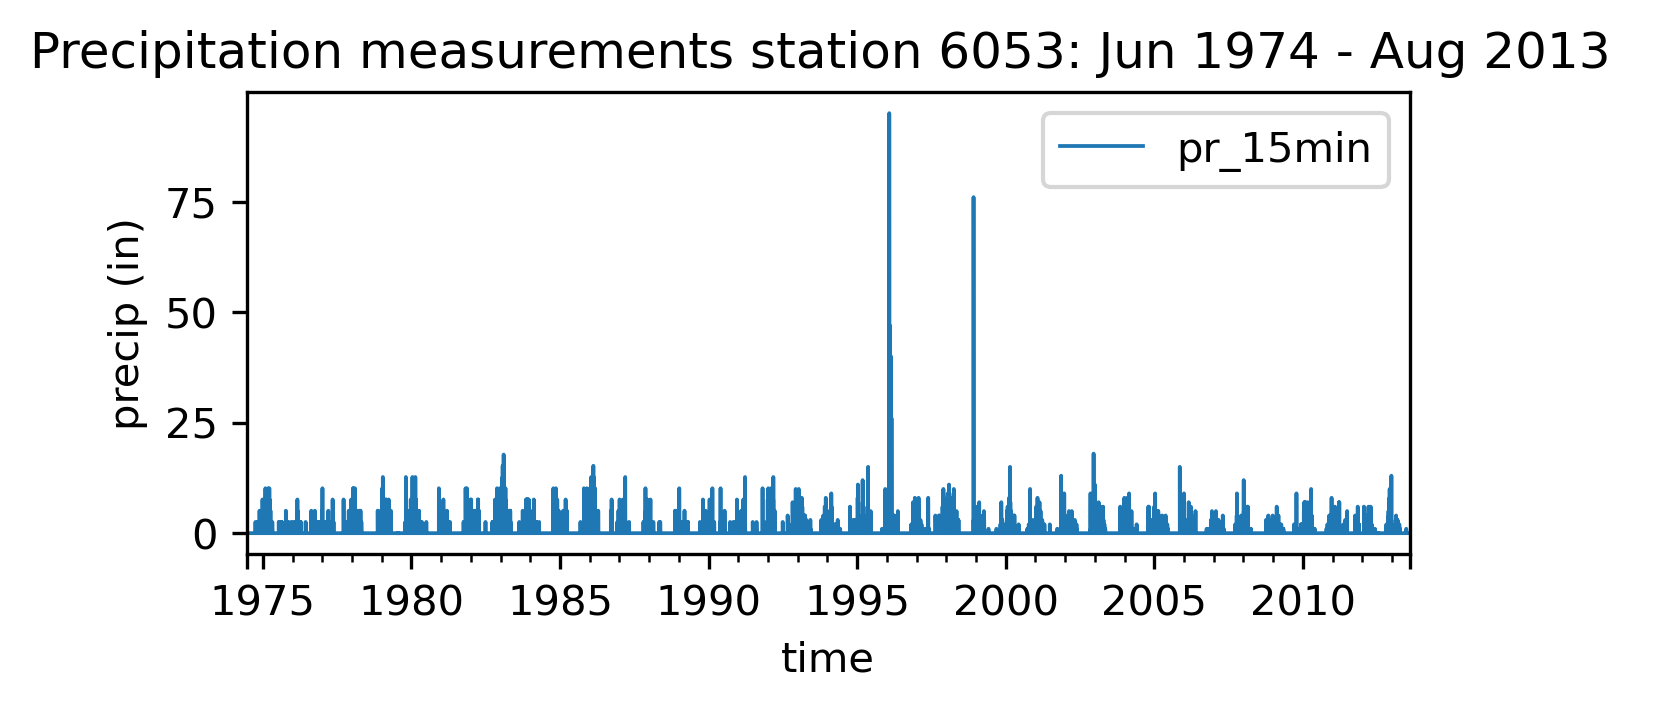

In [ ]:
# Plot the data 
# time_str = df_6053_cleaned["time"].dt.strftime('%b %Y').values

# ax = df_6053_cleaned.plot("time","pr_15min", 
#         figsize=(5,2), 
#         title=f"Precipitation measurements station 6053: {time_str[0]} - {time_str[-1]} ", 
#         ylabel="precip (in)", 
#         linewidth=0.9
#         )

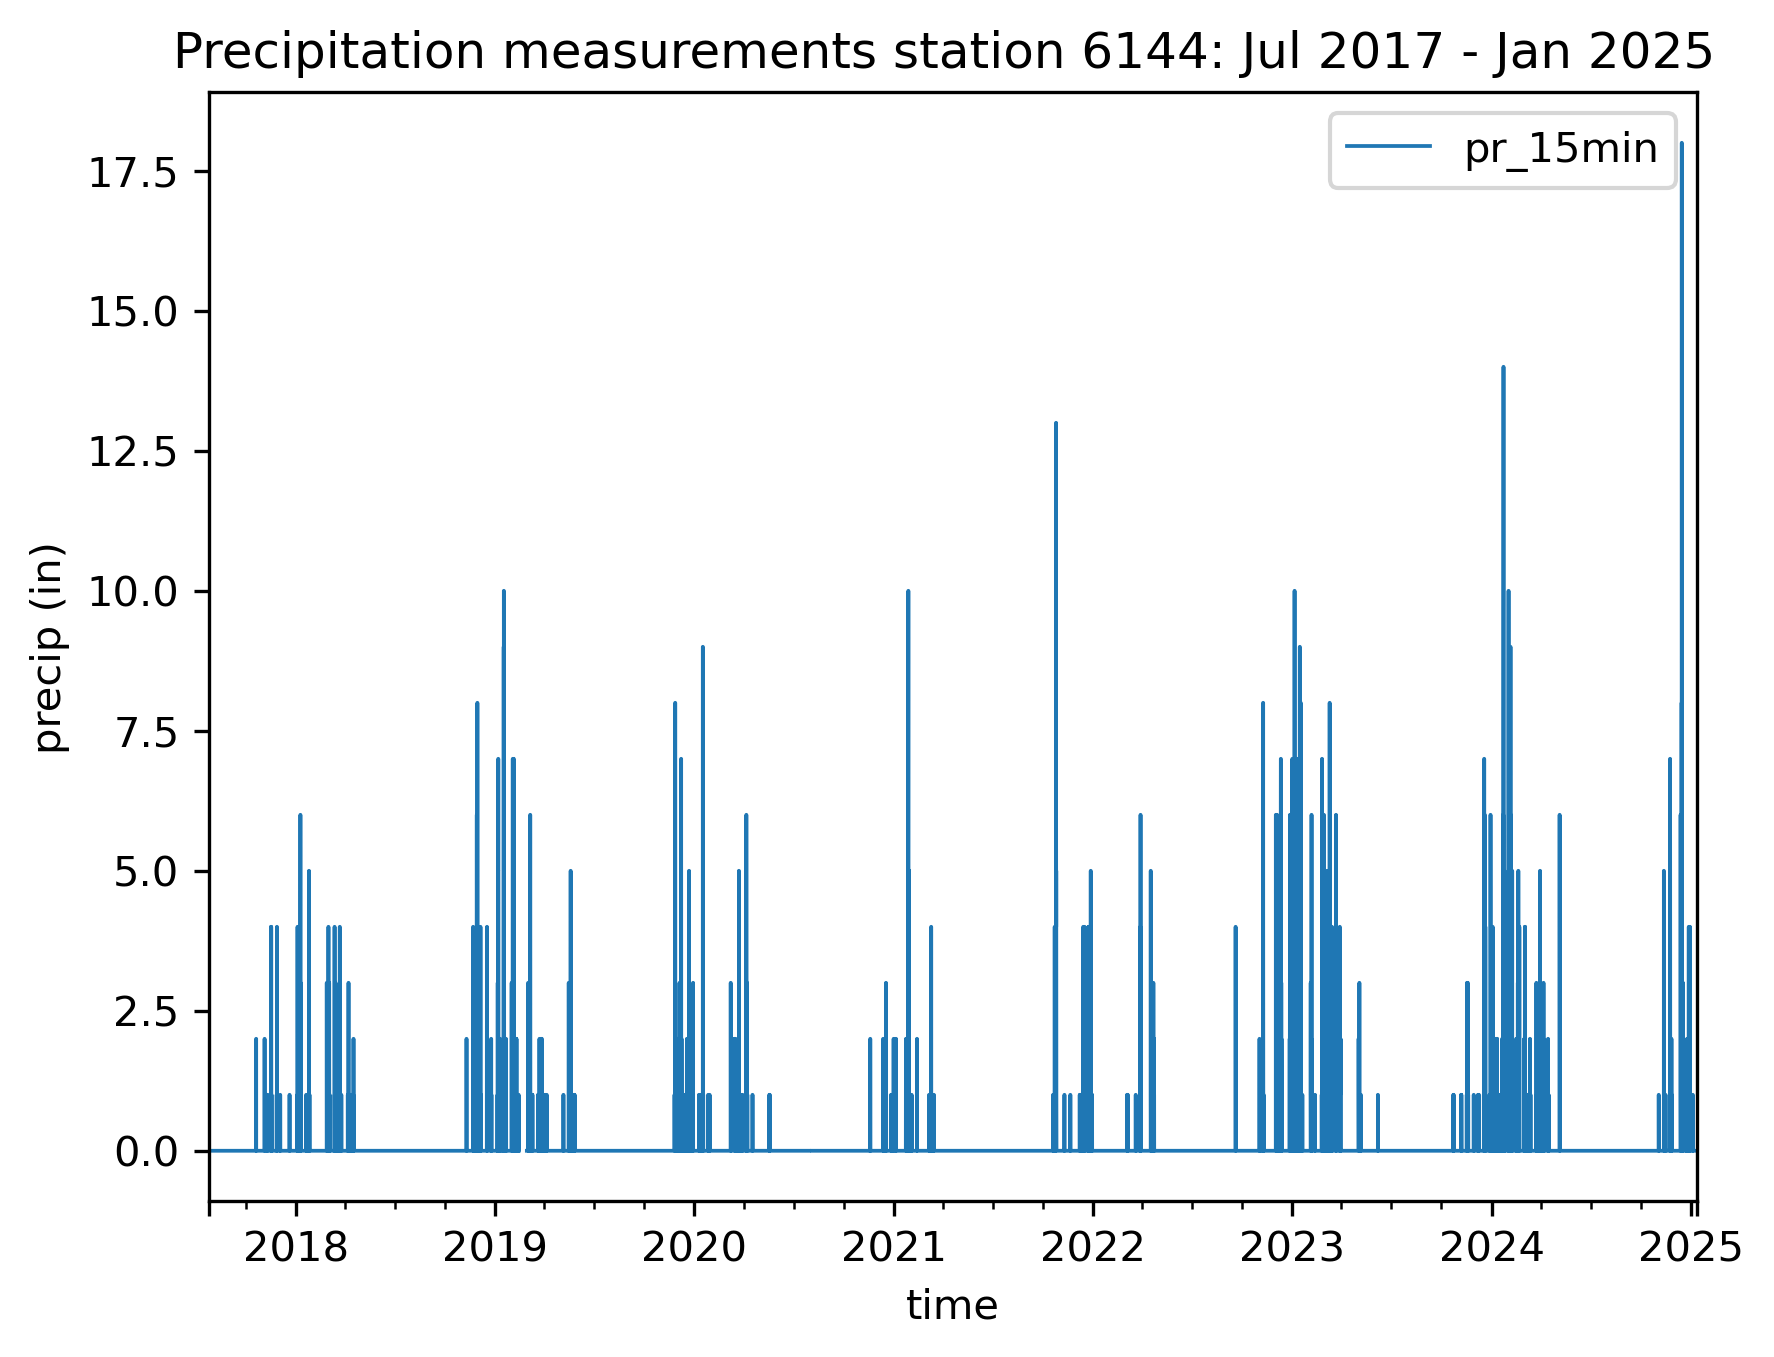

In [ ]:
# Plot the data 
# time_str = df_6144_cleaned["time"].dt.strftime('%b %Y').values

# ax = df_6144_cleaned.plot("time","pr_15min", 
#         figsize=(5,2), 
#         title=f"Precipitation measurements station 6144: {time_str[0]} - {time_str[-1]} ", 
#         ylabel="precip (in)", 
#         linewidth=0.9
#         )